In [7]:
from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

In [3]:
# Load datasets
dfAbnormal1 = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal1 = pd.read_csv("../cleanData/clean_normal.csv")
dfAbnormal = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal = pd.read_csv("../cleanData/clean_normal.csv")


dfAbnormal_1 = pd.concat([dfAbnormal, dfAbnormal1], ignore_index=True)
dfnormal_1 = pd.concat([dfnormal, dfnormal1], ignore_index=True)

# Combine datasets and add label columns
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)

# Separate features and target
X = df_combined.drop(columns='Label')
y = df_combined['Label']

# Apply VarianceThreshold
threshold = 5 # Adjust this value as needed
selector = VarianceThreshold(threshold=threshold)
X_new = selector.fit_transform(X)

# Get selected feature names
selected_features = X.columns[selector.get_support(indices=True)]
print(f'Selected features using VarianceThreshold with threshold {threshold}:')
for feature in selected_features:
    print(feature)

Selected features using VarianceThreshold with threshold 5:
TOTAL_UF
BLOOD_FLOW
CONDUCTIVITY
VENOUS
TEMP
MAX_BLOOD
MIN_BLOOD
PULSE
TMP
TARGET_UF
UF
SYRINGE_FLOW_RATE
TIMES
DIA_FLOW


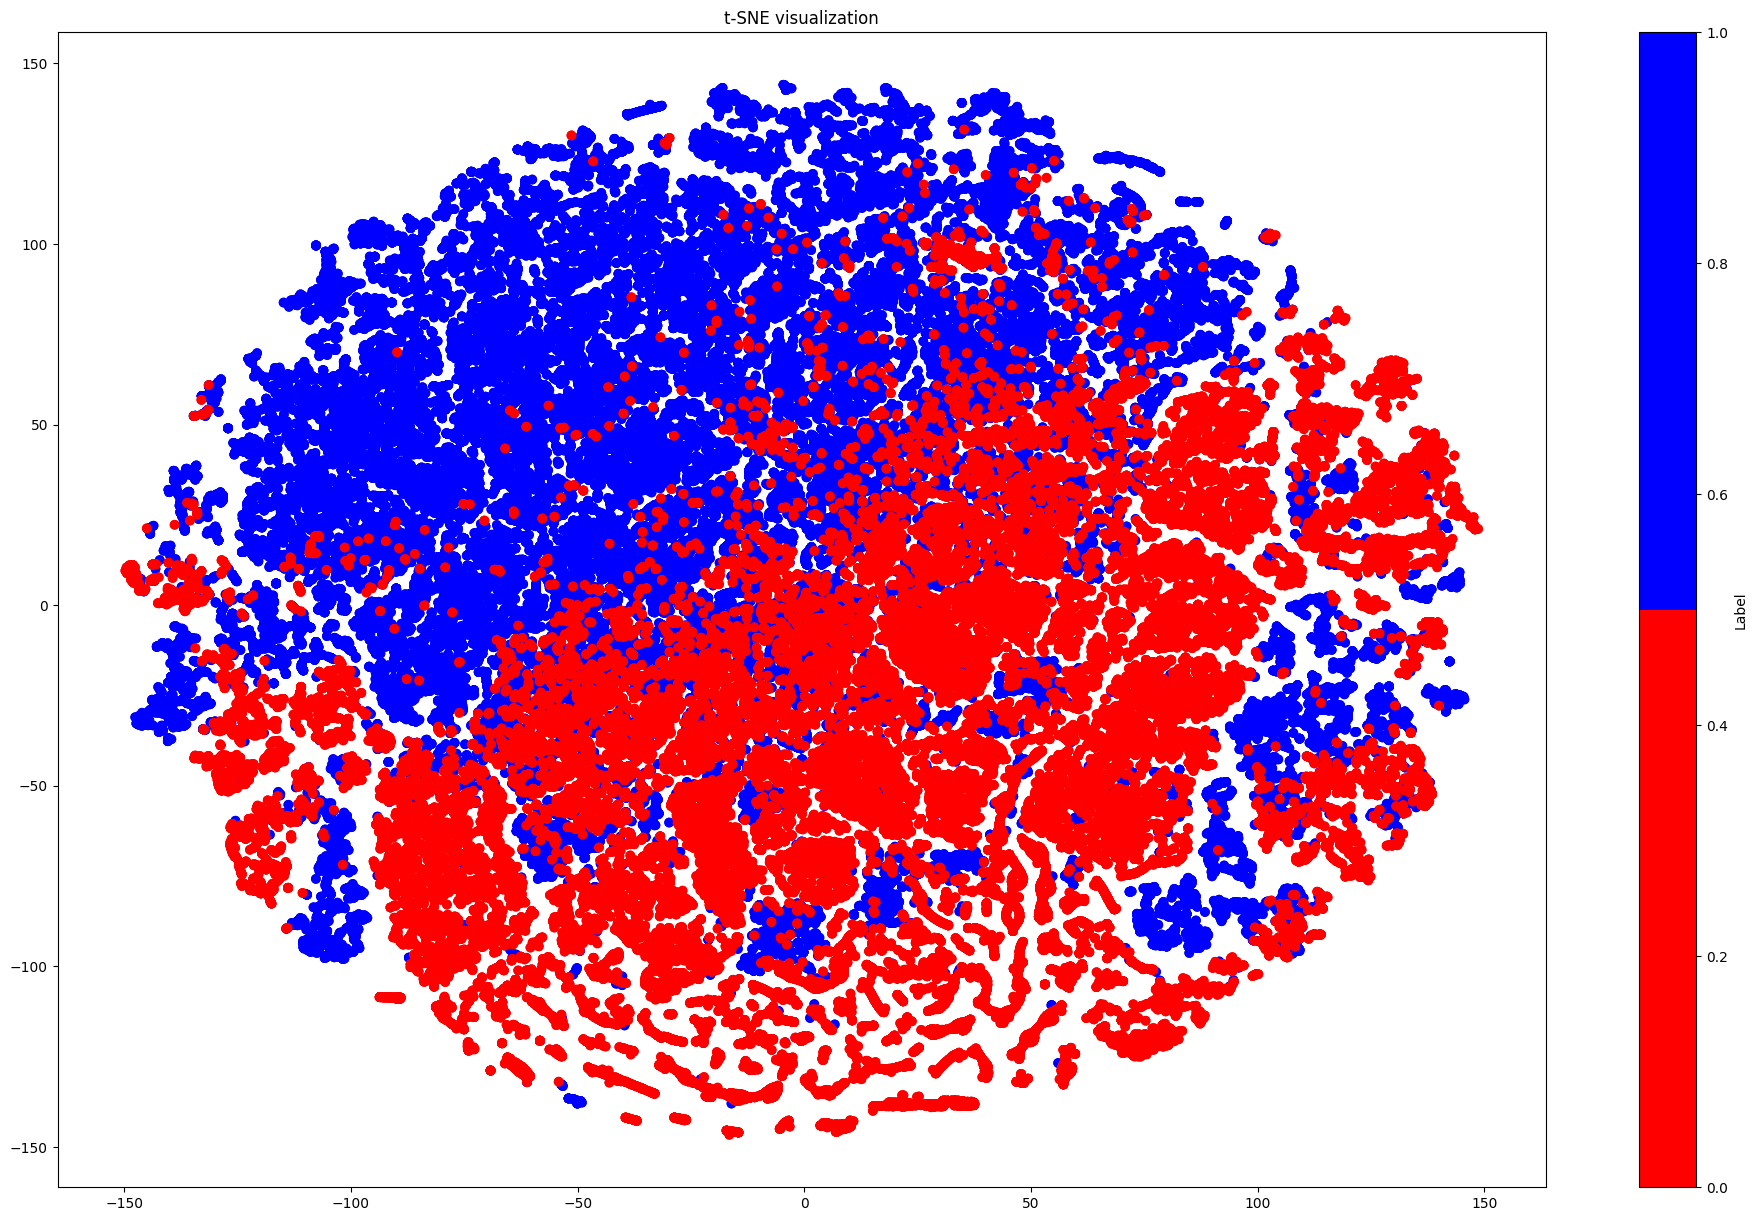

In [4]:
# Create a new dataframe with selected features and labels
df_selected = pd.DataFrame(X_new, columns=selected_features)
df_selected['Label'] = y.values

# Standardize the data
X_standardized = StandardScaler().fit_transform(df_selected.drop(columns='Label'))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_standardized)

# Create a new dataframe with t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = df_selected['Label']

# Plot t-SNE results
plt.figure(figsize=(24, 15))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE visualization')
plt.colorbar(scatter, label='Label')
plt.show()


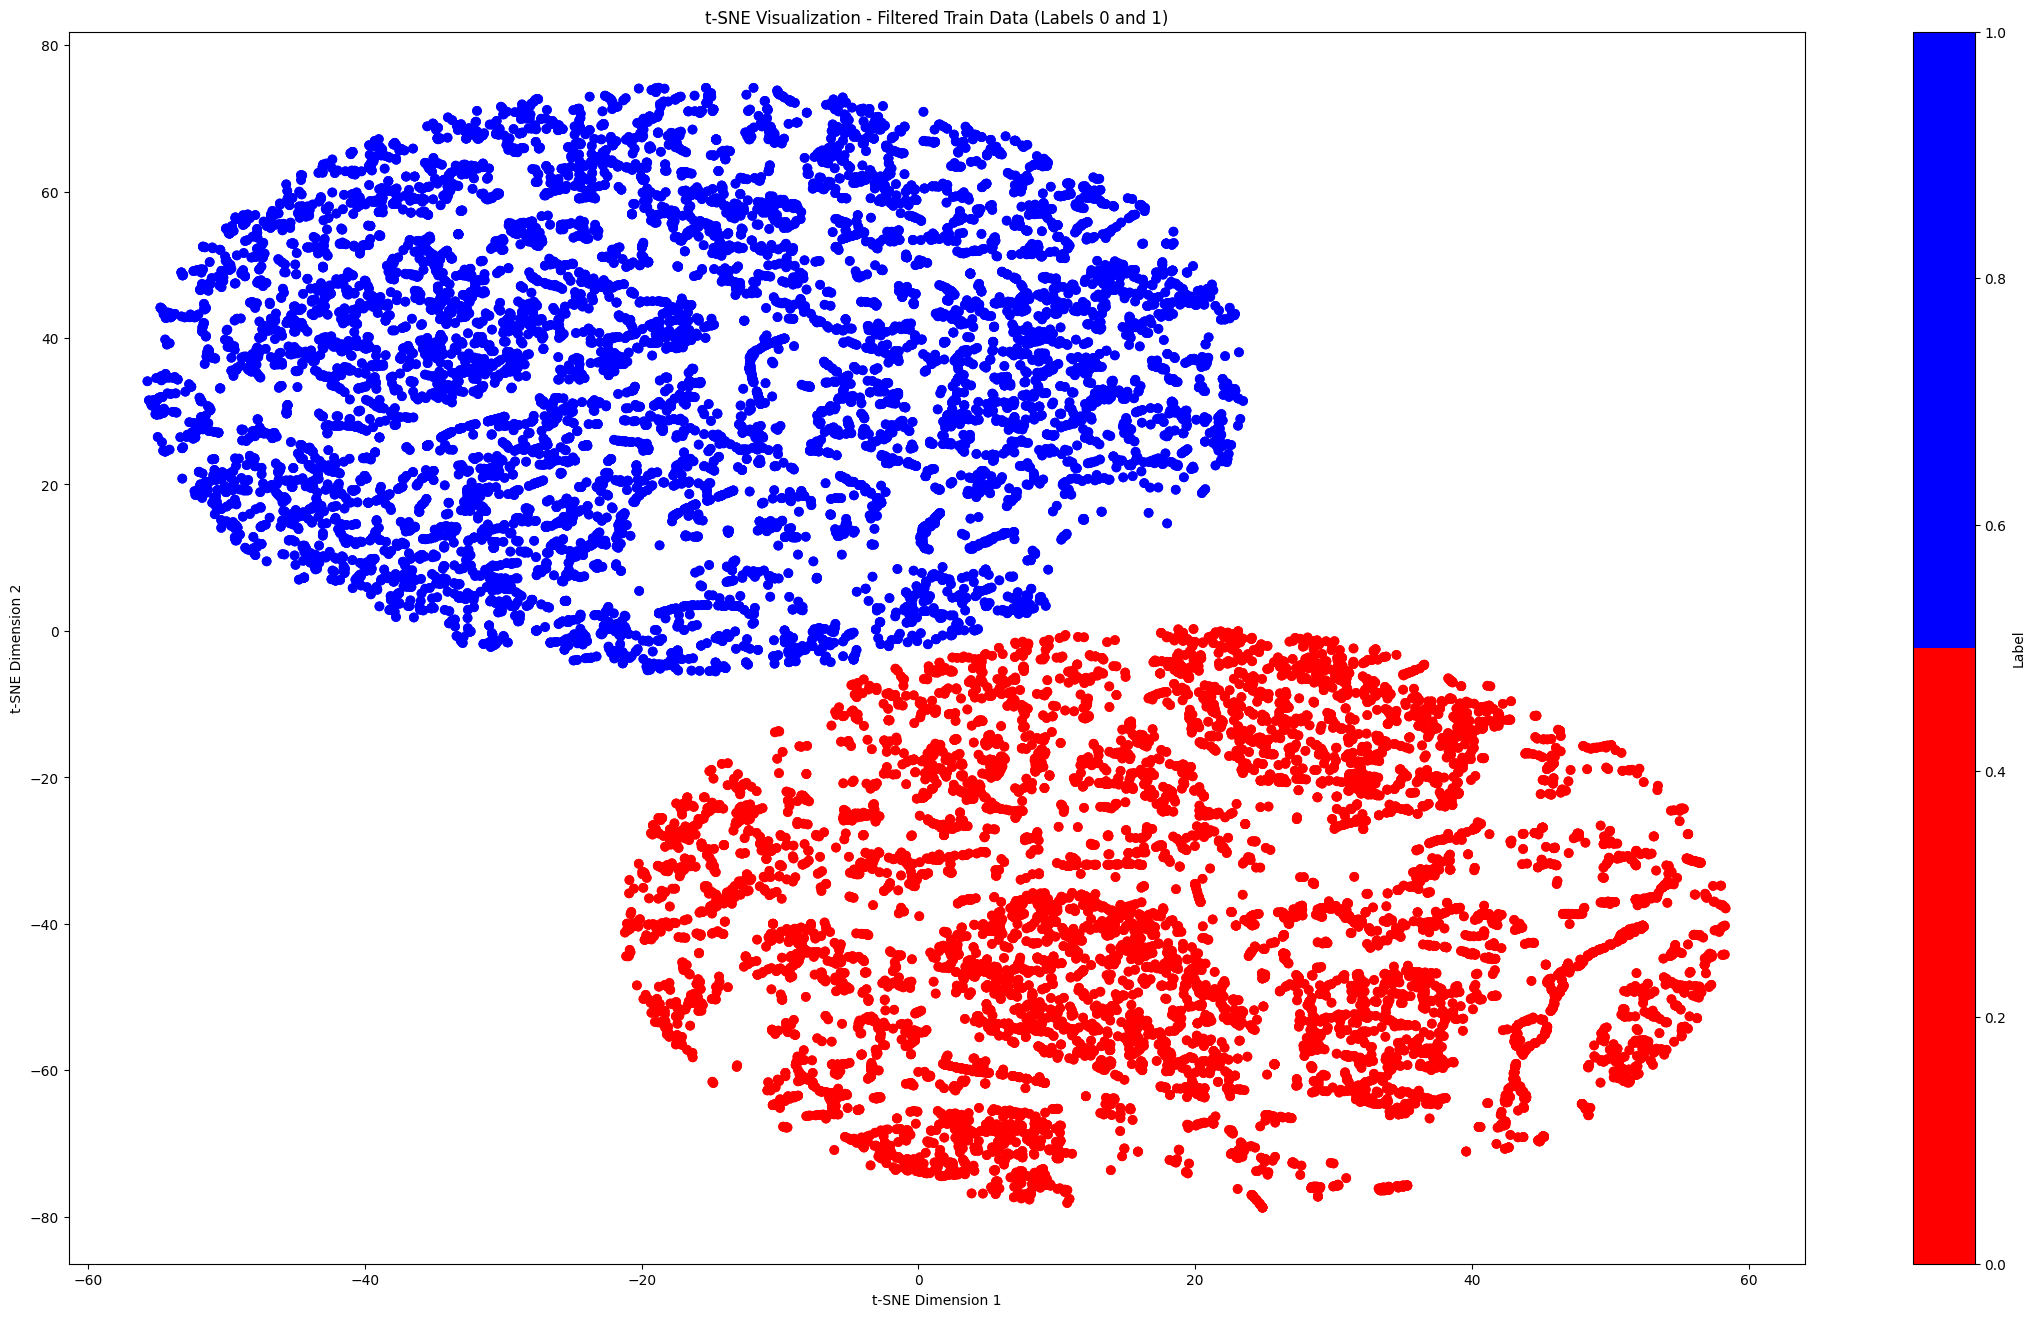

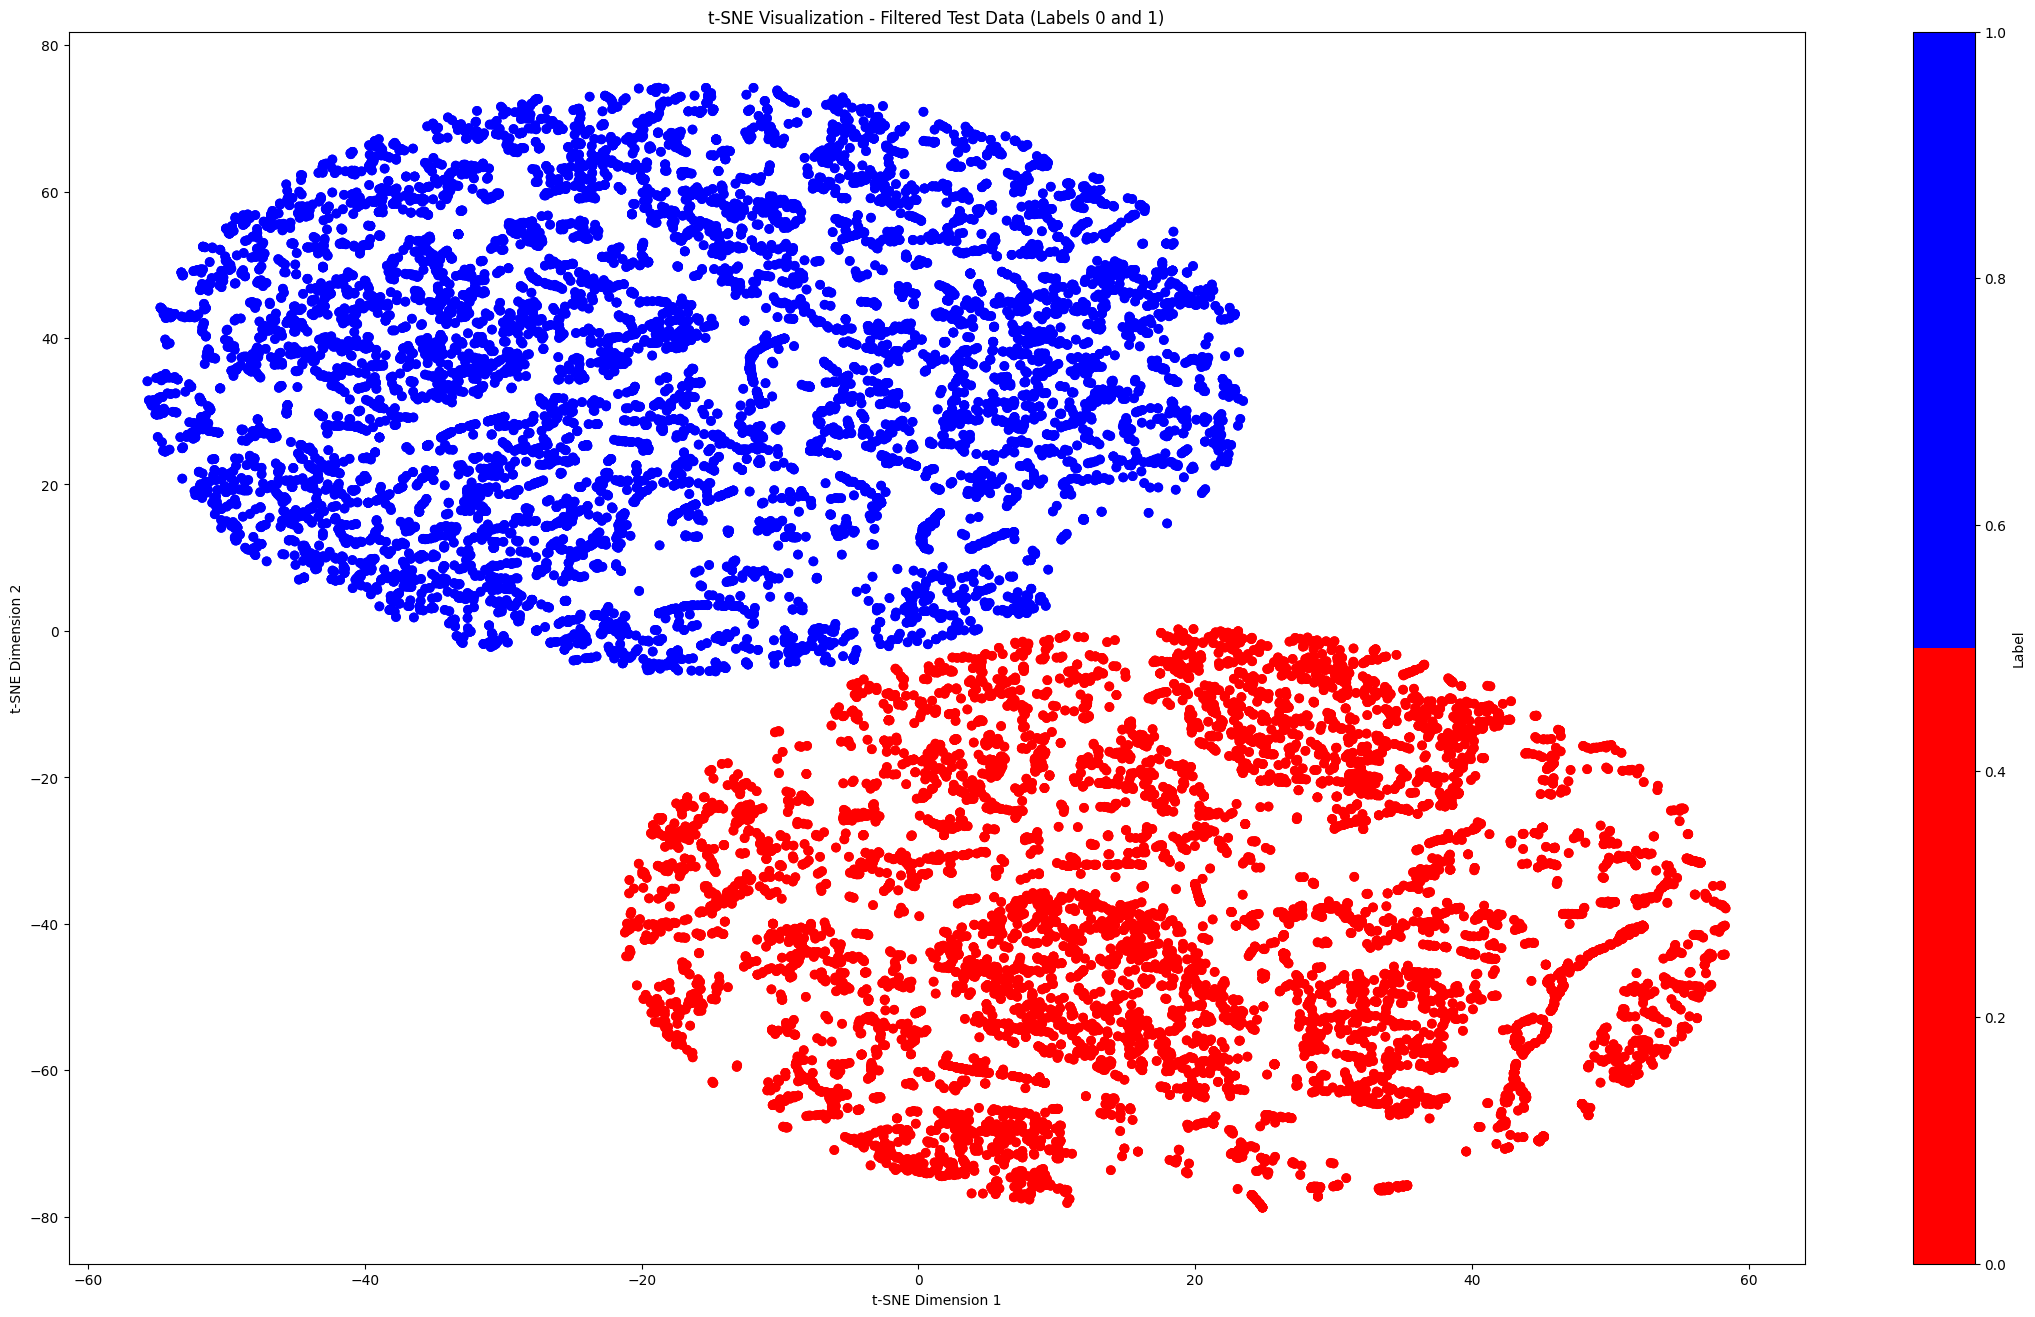

In [9]:
# 将数据分为训练和测试集 (这里需要您具体的训练和测试集划分逻辑)
# 在此示例中，假设所有数据都是训练数据（请根据实际情况进行修改）
train_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values
train_labels = df_tsne['Label'].values
test_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values
test_labels = df_tsne['Label'].values

# 计算类别的中心点
def compute_class_centers(points, labels):
    unique_labels = np.unique(labels)
    centers = {}
    for label in unique_labels:
        centers[label] = np.mean(points[labels == label], axis=0)
    return centers

# 定义阈值来过滤数据
distance_threshold = 40  # 这是一个示例阈值，请根据实际情况调整

# 筛选标签为0和1的训练数据点
train_mask = np.isin(train_labels, [0, 1])
train_tsne_embedded_01 = train_tsne_embedded[train_mask]
train_labels_01 = train_labels[train_mask]

# 筛选标签为0和1的测试数据点
test_mask = np.isin(test_labels, [0, 1])
test_tsne_embedded_01 = test_tsne_embedded[test_mask]
test_labels_01 = test_labels[test_mask]

# 计算训练数据的类别中心
train_class_centers = compute_class_centers(train_tsne_embedded_01, train_labels_01)

# 过滤训练数据
filtered_train_points = []
filtered_train_labels = []
for i, point in enumerate(train_tsne_embedded_01):
    label = train_labels_01[i]
    center = train_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_train_points.append(point)
        filtered_train_labels.append(label)

filtered_train_points = np.array(filtered_train_points)
filtered_train_labels = np.array(filtered_train_labels)

# 计算测试数据的类别中心
test_class_centers = compute_class_centers(test_tsne_embedded_01, test_labels_01)

# 过滤测试数据
filtered_test_points = []
filtered_test_labels = []
for i, point in enumerate(test_tsne_embedded_01):
    label = test_labels_01[i]
    center = test_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_test_points.append(point)
        filtered_test_labels.append(label)

filtered_test_points = np.array(filtered_test_points)
filtered_test_labels = np.array(filtered_test_labels)

# 可视化过滤后的训练数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_train_points[:, 0], filtered_train_points[:, 1], c=filtered_train_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Train Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# 可视化过滤后的测试数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_test_points[:, 0], filtered_test_points[:, 1], c=filtered_test_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Test Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [12]:
# 创建一个哈希表，以加快查找速度
point_to_index = {tuple(point): index for index, point in enumerate(train_tsne_embedded)}

# 使用哈希表查找每个点的索引
indices = np.array([point_to_index[tuple(point)] for point in filtered_train_points])

selected_rows = df_selected.iloc[indices]

df_final = pd.DataFrame(selected_rows)

In [13]:
df_final

,TOTAL_UF,BLOOD_FLOW,CONDUCTIVITY,VENOUS,TEMP,MAX_BLOOD,MIN_BLOOD,PULSE,TMP,TARGET_UF,UF,SYRINGE_FLOW_RATE,TIMES,DIA_FLOW,Label
56656,2.395,270.0,14.1,151.0,36.1,139.0,59.0,83.0,73.0,2.90,0.651,4.9,178.0,492.0,1
56700,2.112,270.0,14.5,148.0,36.1,121.0,53.0,74.0,59.0,3.60,0.935,0.5,130.0,513.0,1
56723,1.496,270.0,14.2,157.0,36.1,111.0,45.0,76.0,66.0,3.30,0.851,0.5,98.0,492.0,1
56727,1.770,270.0,14.2,133.0,36.1,105.0,41.0,75.0,57.0,1.77,0.000,0.5,126.0,506.0,1
56728,1.773,270.0,14.2,127.0,36.1,105.0,41.0,75.0,70.0,3.00,0.744,0.5,127.0,486.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207664,1.645,221.0,14.1,69.0,36.9,157.0,63.0,63.0,65.0,3.30,0.825,1.0,120.0,479.0,0
207665,1.771,0.0,14.1,63.0,36.9,157.0,63.0,63.0,63.0,3.30,0.825,1.0,129.0,473.0,0
207666,1.772,221.0,14.1,81.0,36.9,157.0,63.0,63.0,66.0,3.30,0.825,1.0,129.0,467.0,0
207667,1.775,221.0,14.1,88.0,36.9,157.0,63.0,63.0,54.0,3.50,0.934,1.0,130.0,506.0,0


In [14]:
df_final.to_csv("../cnnData/variance.csv")